# Supplementary Fig. 10: Recombination rates

- Of the total of 1,277 genetic markers published by Mitros et al., Dev. Bio 2019 <https://doi.org/10.1016/j.ydbio.2019.03.015>, we considered 1,168 (91.5%) markers whose genetic distance was equal or lower than the distance of the marker immediately adjacent to the right.  Recombination rates were calculated using the first derivative of the interpolated genetic distances.



In [8]:
#Paths to files:
##Input files:
import os

source_data_path = 'SourceData'
sup_fig = 'Supplementary_Fig.10'

paths_files = os.path.join(source_data_path, sup_fig)

#Input files
file_path_centrome_pos = os.path.join(source_data_path, 'Supplementary_Fig.2', 'Supplementary_Fig.2a', 'Xtr_centromeric_repeats.tsv')
chromosome_sizes_file = os.path.join(paths_files, 'All_Chr_lengths.tsv')
genetic_map_file =  os.path.join(paths_files, 'finalV10Map.joinmap.toplot.tsv')
genetic_map_version = '_Final'

#Setup out file:
out_dir_figs = paths_files

rec_rate_file_out = os.path.join(out_dir_figs, 'Xtropicalis_Recombination_Rates_Final.tsv')


In [9]:
import pandas as pd
import numpy as np
import seaborn  as sns
import matplotlib.pyplot as plt
from scipy import stats


def load_all_chromosome_sizes(file_path, Spe_abr):
    chr_sizes = pd.read_csv(file_path, sep='\t')  
    if Spe_abr== '':
        chr_sizes =chr_sizes[chr_sizes.Abr=='Chr']
    else:
        chr_sizes =chr_sizes[chr_sizes.Abr==Spe_abr]
    return(chr_sizes)

#Dataframe for Chromosome sizes:
Specie_name = 'Xtropicalis'
chr_sizes = load_all_chromosome_sizes(chromosome_sizes_file, 'Xtr')

Genetic_map = pd.read_csv(genetic_map_file, sep='\t')
Genetic_map['Pos'] = Genetic_map.Pos.astype(int)
Genetic_map = Genetic_map.sort_values(['Chr','Pos'], ascending=[True,True])

Xtrop_centromere_positon = pd.read_csv(file_path_centrome_pos, sep='\t') 




In [13]:
# This is the good one! # linear > Cubic spline
# Linear interpolation for every 3Mb
# Then cubicSplice for every 1Mb

from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

Mb = 1000000

def obtain_increasing_cMs(cM, pos):
    prev_i = cM[0]
    prev_pos= pos[0]
    positive_cM_arr = []
    positive_pos_arr = []
    positive_cM_arr.append(prev_i)
    positive_pos_arr.append(prev_pos)
    for i in range(0, len(cM)):
        if (cM[i]>= prev_i ) & (prev_pos<pos[i]):
            prev_i = cM[i]
            positive_cM_arr.append(cM[i])        
            positive_pos_arr.append(pos[i])
            prev_i = cM[i]
            prev_pos = pos[i]
    return(positive_cM_arr, positive_pos_arr)

def linear_genetic_map(Genetic_map, chr_sizes , win_size):
    # The genetic map distances were linearly interpolated using a 3 Mb window size, the interpolated values were smoothed using cubic splines 1 Mbps.
    
    win_size = int(win_size)

    Mb = 1000000
    #win_size = Mb*3
    
    RecombinationRate = pd.DataFrame()
    for each_chr  in chr_sizes.Chr.to_list():
        chr_size_ = int(list(chr_sizes[chr_sizes.Chr==each_chr].Length)[0])
        
        RecombinationRate_df = pd.DataFrame() 
        
        pos = np.array(Genetic_map[Genetic_map['Chr']==each_chr].Pos.tolist()) 
        cM =  np.array(Genetic_map[Genetic_map['Chr']==each_chr].cM.tolist()) 

        cM, pos = obtain_increasing_cMs(cM, pos)
        cont_positon = np.array(range(min(pos), max(pos), win_size))
        if cont_positon[-1] < max(pos):
            cont_positon = np.append(cont_positon,pos[-1])
        
        lin_interpolation = interp1d(np.array(pos), np.array(cM))
        y1 = lin_interpolation(cont_positon)
        
        cs = CubicSpline(cont_positon, y1)

        cont_positon2 = np.array(range(int(min(Genetic_map[Genetic_map['Chr']==each_chr].Pos)), int(max(Genetic_map[Genetic_map['Chr']==each_chr].Pos)+Mb/2), int(Mb/2)))        
        y2 = cs(cont_positon2)
        
        RecombinationRate_df['Chr'] = [each_chr]*len(cont_positon2)
        RecombinationRate_df['Pos'] = list(cont_positon2 )
        RecombinationRate_df['Pos'] = RecombinationRate_df.Pos.astype(int)
        RecombinationRate_df['delta_pos'] = list(np.array(RecombinationRate_df['Pos'])[1:]-np.array(RecombinationRate_df['Pos'])[:-1]) +[0]
        RecombinationRate_df['Smooth_Genetic_distance'] = y2
        RecombinationRate_df['delta_CC'] = list(np.array(RecombinationRate_df['Smooth_Genetic_distance'])[1:]-np.array(RecombinationRate_df['Smooth_Genetic_distance'])[:-1]) + [0]
        RecombinationRate_df['Smooth_Recombination_Rate'] =  RecombinationRate_df['delta_CC']*Mb/RecombinationRate_df['delta_pos']
        
        RecombinationRate = pd.concat((RecombinationRate,RecombinationRate_df), ignore_index=True)
        
    RecombinationRate = RecombinationRate[['Chr','Pos','delta_pos','delta_CC','Smooth_Genetic_distance','Smooth_Recombination_Rate']]
    RecombinationRate = RecombinationRate#.reset_index()
    return(RecombinationRate)



win_size = 2.5*Mb
Rec_rate = linear_genetic_map(Genetic_map, chr_sizes, win_size)

Rec_rate['Start'] = Rec_rate.Pos +  Rec_rate.delta_pos/2

Rec_rate_file = ''.join((out_dir_figs,Specie_name,'_Recombination_Rates',genetic_map_version,'.tab'))
print("Saved Recombination rates as: ",Rec_rate_file)

Rec_rate.loc[Rec_rate.Smooth_Recombination_Rate<0,'Smooth_Recombination_Rate'] = 0


High_rec_lim = Rec_rate.Smooth_Recombination_Rate.median() + .75*Rec_rate.Smooth_Recombination_Rate.std()
print("High_rec_lim = ", High_rec_lim)
Rec_rate['Rec_rate']= 'Low'
Rec_rate.loc[Rec_rate.Smooth_Recombination_Rate>=High_rec_lim, 'Rec_rate' ] ='High'


Total_chr_size_inMb = chr_sizes.Length.sum()/Mb
Positions_from_genetic_map = int(Genetic_map.groupby('Chr').agg({'Pos': lambda x: max(x)-min(x)}).sum()/Mb)
Total_portionGenome_weObtained_RecombinationRate = int(Rec_rate.groupby('Chr').agg({'Pos': lambda x: max(x)-min(x)}).sum()/Mb)
Percentage_genome_weObtained_RecombinationRate = Total_portionGenome_weObtained_RecombinationRate/float(Total_chr_size_inMb)

print("Total_chr_size_inMb", Total_chr_size_inMb)
print("Total_portionGenome_weObtained_RecombinationRate", Total_portionGenome_weObtained_RecombinationRate)
print("% genome with RecombinationRate values", Percentage_genome_weObtained_RecombinationRate*100)



Saved Recombination rates as:  SourceData/Supplementary_Fig.10Xtropicalis_Recombination_Rates_Final.tab
High_rec_lim =  1.1542384865861957
Total_chr_size_inMb 1449.31964
Total_portionGenome_weObtained_RecombinationRate 1349
% genome with RecombinationRate values 93.07815631339959


In [14]:
# Include Chromosome region in Recombination rate dataframe.

Mb = 1000000
Subtel_size =  30*Mb

Rec_rate.loc[Rec_rate.Pos<=Subtel_size,'Chr domain'] = 'p-Subtelomere'
Rec_rate.loc[Rec_rate.Pos>Subtel_size,'Chr domain'] = 'Arms'

for i in Rec_rate.Chr.unique():
    cent_pos = Xtrop_centromere_positon[(Xtrop_centromere_positon.Chr==i)].TandemRepeats.to_list()[0]
    chr_size=chr_sizes[chr_sizes.Chr==i].Length.to_list()[0]
    Rec_rate.loc[(Rec_rate.Chr==i) &(Rec_rate.Pos>cent_pos),'Chr domain'] = 'Arms'
    Rec_rate.loc[(Rec_rate.Chr==i) &(Rec_rate.Pos>=chr_size-Subtel_size),'Chr domain']='q-Subtelomere'
    Rec_rate.loc[(Rec_rate.Chr==i) &(Rec_rate.Pos>=cent_pos-5*Mb)&(Rec_rate.Pos<=cent_pos+5*Mb),'Chr domain']='Pericentromere'
    
Rec_rate['Chr domains']=Rec_rate['Chr domain']
#Rec_rate.loc[(Rec_rate['Chr domains'].str.contains('Subtel')) & (Rec_rate['Chr domains'].isnull()==False),'Chr domains'] = 'Subtelomere'
Rec_rate.loc[(Rec_rate['Chr domains'].str.contains('Subtel')),'Chr domains'] = 'Subtelomeres'


Rec_rate.head()

Chr      Pos  delta_pos  delta_CC  Smooth_Genetic_distance  \
0  Chr1  4000000     500000  0.845459                 0.000000   
1  Chr1  4500000     500000  1.021646                 0.845459   
2  Chr1  5000000     500000  1.181592                 1.867105   
3  Chr1  5500000     500000  1.325296                 3.048697   
4  Chr1  6000000     500000  1.452757                 4.373993   

   Smooth_Recombination_Rate      Start Rec_rate     Chr domain   Chr domains  
0                   1.690918  4250000.0     High  p-Subtelomere  Subtelomeres  
1                   2.043293  4750000.0     High  p-Subtelomere  Subtelomeres  
2                   2.363184  5250000.0     High  p-Subtelomere  Subtelomeres  
3                   2.650591  5750000.0     High  p-Subtelomere  Subtelomeres  
4                   2.905515  6250000.0     High  p-Subtelomere  Subtelomeres

In [15]:

Rec_rate.to_csv(rec_rate_file_out, sep='\t', index=False)
print("Saved Recombination rates as: ",rec_rate_file_out)


Saved Recombination rates as:  SourceData/Supplementary_Fig.10/Xtropicalis_Recombination_Rates_Final.tsv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved as SourceData/Supplementary_Fig.10/Xtropicalis_Recombination.pdf


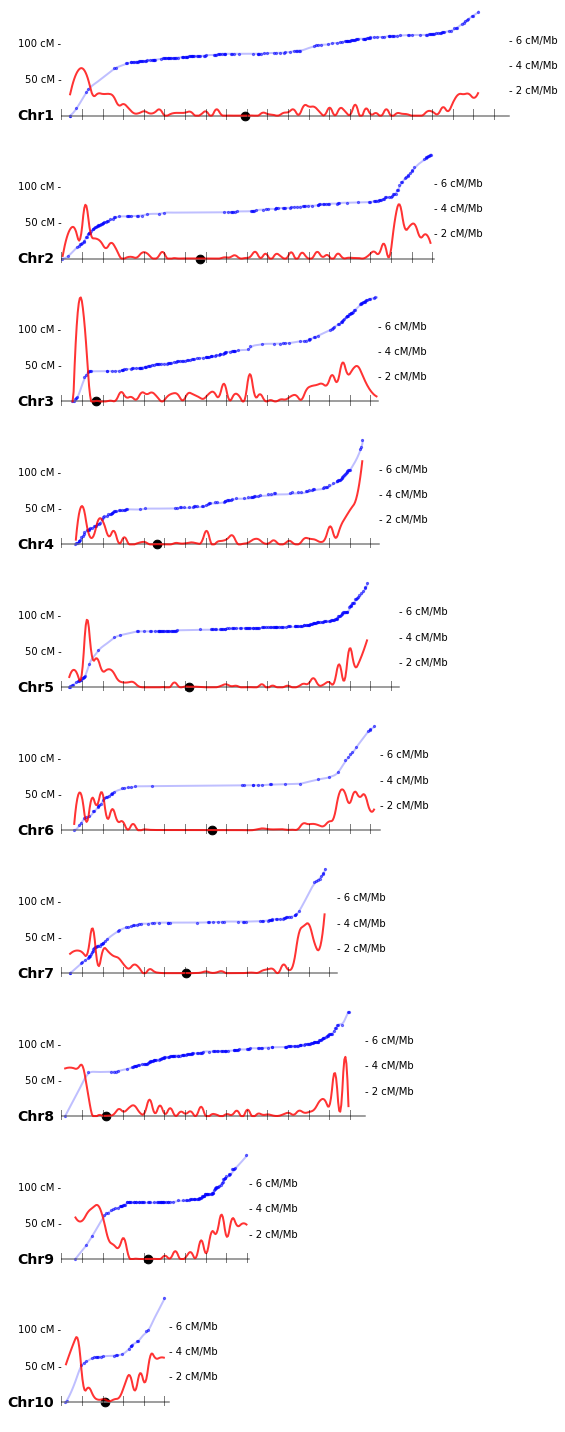

In [17]:
# Sup. Fig 10a:

Mb = 1000000

title = 'Recombination'

list_chromosomes = chr_sizes.Chr.tolist()
CTR_pos_Chr1 = list(Xtrop_centromere_positon[Xtrop_centromere_positon.Chr=='Chr1'].TandemRepeats)[0]
Largest_chr_len = float(chr_sizes.Length.max())*1.1


max_y_value, max_axis = 1,1
min_axis = -.2

counter = 0
fig, axs = plt.subplots(len(list_chromosomes), figsize=(8,2*len(list_chromosomes)))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for Chr_ in list_chromosomes:
    Chr_size_ = list(chr_sizes[chr_sizes.Chr==Chr_].Length)[0]
    CTR_pos = list(Xtrop_centromere_positon[Xtrop_centromere_positon.Chr==Chr_].TandemRepeats)[0]
    delta_centromere = 0 
    CTR_pos_normalized =(CTR_pos+delta_centromere)/Largest_chr_len
    chr_size_normalized = (Chr_size_+delta_centromere)/Largest_chr_len
    
    axs[counter].set_xlim((0, 1))
    axs[counter].set_ylim((min_axis*1.1, 1.05))
    #axs[counter].text(-.01, 1.05, Chr_, fontsize=14, ha='left')
    axs[counter].text(-.015, 0, Chr_, fontsize=14, ha='right', va='center', fontweight='bold')
    axs[counter].axhline(0,xmin=delta_centromere/Largest_chr_len, xmax=chr_size_normalized, color='gray')
  
    cM_ = np.array(Genetic_map[Genetic_map.Chr==Chr_].cM)
    pos_ = np.array((Genetic_map[Genetic_map.Chr==Chr_].Pos))
    cM_inc = pd.Series(obtain_increasing_cMs(cM_, pos_)[0])
    pos_inc = pd.Series(obtain_increasing_cMs(cM_, pos_)[1])
    axs[counter].scatter((pos_inc+ delta_centromere)/Largest_chr_len, cM_inc/max(cM_inc), color='blue', s=5, alpha=.5)
    axs[counter].plot((Rec_rate[Rec_rate.Chr==Chr_].Start)/Largest_chr_len, Rec_rate[Rec_rate.Chr==Chr_].Smooth_Genetic_distance/max(Rec_rate[Rec_rate.Chr==Chr_].Smooth_Genetic_distance), alpha=0.25, linewidth=2, color='blue')
  
    axs[counter].spines['top'].set_visible(False)
    axs[counter].spines['right'].set_visible(False)
    axs[counter].spines['bottom'].set_visible(False)
    axs[counter].spines['left'].set_visible(False)
    axs[counter].get_xaxis().set_ticks([])
    axs[counter].get_yaxis().set_ticks([])
    
    if len(Rec_rate) > 0:
        x_positon = (Rec_rate[Rec_rate.Chr==Chr_]['Pos'] + Rec_rate[Rec_rate.Chr==Chr_].delta_pos/2) + delta_centromere
        x_positon_normalized = (x_positon)/Largest_chr_len
        axs[counter].plot(x_positon_normalized,Rec_rate[Rec_rate.Chr==Chr_].Smooth_Recombination_Rate/Rec_rate.Smooth_Recombination_Rate.max(), color='red', linewidth=2, alpha=0.8)


    #Right ticks
    for y_pos in range(0,int(Rec_rate.Smooth_Recombination_Rate.max()),2):
        if y_pos>0:
            axs[counter].text(Chr_size_/Largest_chr_len,y_pos/Rec_rate.Smooth_Recombination_Rate.max(),''.join(('- ',str(y_pos),' cM/Mb')), fontsize=10, horizontalalignment='left',va='center')
    #Left ticks
    for y_pos in range(0,int(Rec_rate.Smooth_Genetic_distance.max()),50):
        if y_pos>0:
            axs[counter].text(0,y_pos/Rec_rate.Smooth_Genetic_distance.max(),''.join((str(y_pos),' cM',' -')), fontsize=10, horizontalalignment='right',va='center')

            
    axs[counter].scatter(CTR_pos_normalized, 0, alpha=1, s=75, facecolor='black', edgecolors='black',  marker="o")#color='white')  # Centromere dot at the center of each chr
    
    for tick_10Mb in range(0, Chr_size_, 10*Mb):
        normalized_tick = (tick_10Mb  +delta_centromere)/Largest_chr_len  
        axs[counter].axvline(normalized_tick, ymin=.15, ymax= .22,  alpha=.5, color='black', linewidth=1)
    counter=counter+1
    
plt.legend(bbox_to_anchor=(.8,1), frameon=False)    
plt.tight_layout()
out_fig_name = os.path.join(out_dir_figs, 'Xtropicalis_'+title+'.pdf')
print("Saved as", out_fig_name)
#plt.savefig(out_fig_name,bbox_inches='tight', transparent=True,)
plt.show()

/tmp/ipykernel_1940846/1785326436.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Rec_rate[~Rec_rate.Smooth_Recombination_Rate.isnull()][["Smooth_Recombination_Rate"]], ax=ax_hist , bins=100)
bio-mpl/lib/python3.9/site-packages/seaborn/_oldcore.py:1592: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


Saved as:  SourceData/Supplementary_Fig.10Xtro_RecRate_Dist.pdf


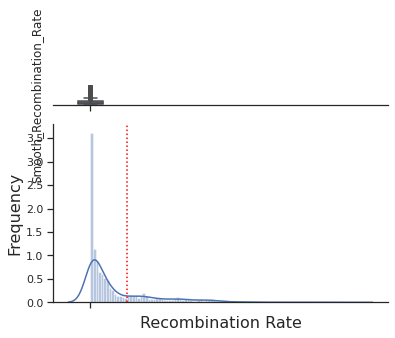

Cumulative Recombination Rate across the X. tropicalis genome
Saved as:  SourceData/Supplementary_Fig.10Xtr_Cum_RecRate.pdf


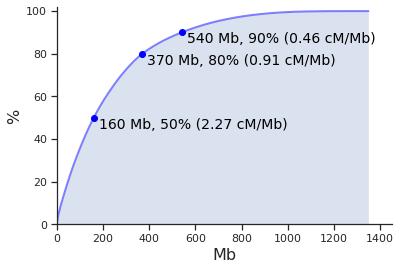

The genome wide avg recombination rate is:  0.7998315118214481
The genome wide median recombination rate is:  0.3041627451186599
The genome wide avg recombination rate** is:  0.8764698540016599
The genome wide median recombination rate** is:  0.3688364069333261
Median(RR) + .5*std(RR)**: 0.9477621040964177
** only considering recombination rates>0
High_rec_lim =  1.1542384865861957


Chr      Pos  delta_pos  delta_CC  Smooth_Genetic_distance  \
0  Chr1  4000000     500000  0.845459                 0.000000   
1  Chr1  4500000     500000  1.021646                 0.845459   
2  Chr1  5000000     500000  1.181592                 1.867105   
3  Chr1  5500000     500000  1.325296                 3.048697   
4  Chr1  6000000     500000  1.452757                 4.373993   

   Smooth_Recombination_Rate      Start Rec_rate     Chr domain   Chr domains  
0                   1.690918  4250000.0     High  p-Subtelomere  Subtelomeres  
1                   2.043293  4750000.0     High  p-Subtelomere  Subtelomeres  
2                   2.363184  5250000.0     High  p-Subtelomere  Subtelomeres  
3                   2.650591  5750000.0     High  p-Subtelomere  Subtelomeres  
4                   2.905515  6250000.0     High  p-Subtelomere  Subtelomeres

In [25]:
# Sup. Fig 10b:



### Plot recombination rate
sns.set(style="ticks")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)})

# Add a graph in each part
sns.distplot(Rec_rate[~Rec_rate.Smooth_Recombination_Rate.isnull()][["Smooth_Recombination_Rate"]], ax=ax_hist , bins=100)
sns.boxplot(data=Rec_rate[~Rec_rate.Smooth_Recombination_Rate.isnull()][["Smooth_Recombination_Rate"]], y='Smooth_Recombination_Rate', order=chr_sizes.Chr.to_list() , orient='horizontal',ax=ax_box)
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.xlabel('Recombination Rate', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.axvline(High_rec_lim, color='red', linestyle=':')
plt.ylim()
fig_name=''.join((out_dir_figs,'Xtro','_RecRate_Dist.pdf'))
print("Saved as: ", fig_name)
plt.savefig(fig_name, bbox_inches='tight' ) 
plt.show()


### #### 
i = 'Cumulative Recombination Rate'
print(i, "across the X. tropicalis genome")

fig, ax = plt.subplots()

phys_distance = list(np.array(range(0,len(Rec_rate[~Rec_rate.Smooth_Recombination_Rate.isnull()].Smooth_Recombination_Rate))))
cum_Rec_Rate = list(100*np.cumsum(sorted(Rec_rate[~Rec_rate.Smooth_Recombination_Rate.isnull()].Smooth_Recombination_Rate, reverse=True))/Rec_rate.Smooth_Recombination_Rate.sum())
DF_cum_Rec_Rate = pd.DataFrame(index=phys_distance)
DF_cum_Rec_Rate['Mb']=DF_cum_Rec_Rate.index.to_series().apply(lambda x: 500000*(x+1)/1000000)
DF_cum_Rec_Rate.loc[:,'Cumulative Recombination Rate'] =cum_Rec_Rate
Rec_Rate_ls = pd.Series(np.array(sorted(Rec_rate[~Rec_rate.Smooth_Recombination_Rate.isnull()].Smooth_Recombination_Rate, reverse=True)))
DF_cum_Rec_Rate.loc[:,'Recombination Rate value'] = Rec_Rate_ls

#plt.figure(figsize=(28,8))
ax.plot(DF_cum_Rec_Rate.Mb,DF_cum_Rec_Rate[i], alpha=0.5, color='blue', linewidth=2)   

plt.fill_between(DF_cum_Rec_Rate.Mb,0,DF_cum_Rec_Rate[i], alpha=0.2)   
#plt.grid()
#plt.title('Cumulative Recombination Rate', fontsize=18)
plt.ylabel('%', fontsize=16)
plt.xlabel('Mb', fontsize=16)
plt.ylim(0,102)
#plt.xticks(range(0,DF_cum_Rec_Rate.index[-1],200), range(0,DF_cum_Rec_Rate.Mb.iloc[-1],200))
plt.xticks(range(0,int(Total_chr_size_inMb),200))
plt.xlim(0,Total_chr_size_inMb)#max(DF_cum_Rec_Rate.Mb))


pctile = 50
Mbs_under = DF_cum_Rec_Rate[(DF_cum_Rec_Rate[i]>pctile-.2) & (DF_cum_Rec_Rate[i]<=pctile)].iloc[-1].Mb
cM_over_Mb = np.array(DF_cum_Rec_Rate[(DF_cum_Rec_Rate[i]>pctile-.2) & (DF_cum_Rec_Rate[i]<=pctile)]['Recombination Rate value'])[-1]
ax.text(Mbs_under+22,pctile-5, ''.join((str(int(Mbs_under)),' Mb, ',str(pctile),'% (',str(cM_over_Mb)[:4],' cM/Mb)')), fontsize=14, color='black')
ax.scatter(Mbs_under,pctile, color='blue')
pctile = 80
Mbs_under = DF_cum_Rec_Rate[(DF_cum_Rec_Rate[i]>pctile-.2) & (DF_cum_Rec_Rate[i]<=pctile)].iloc[-1].Mb
cM_over_Mb = np.array(DF_cum_Rec_Rate[(DF_cum_Rec_Rate[i]>pctile-.2) & (DF_cum_Rec_Rate[i]<=pctile)]['Recombination Rate value'])[-1]
ax.text(Mbs_under+22,pctile-5, ''.join((str(int(Mbs_under)),' Mb, ',str(pctile),'% (',str(cM_over_Mb)[:4],' cM/Mb)')), fontsize=14, color='black')
ax.scatter(Mbs_under,pctile, color='blue')
pctile = 90
Mbs_under = DF_cum_Rec_Rate[(DF_cum_Rec_Rate[i]>pctile-.2) & (DF_cum_Rec_Rate[i]<=pctile)].iloc[-1].Mb
cM_over_Mb = np.array(DF_cum_Rec_Rate[(DF_cum_Rec_Rate[i]>pctile-.2) & (DF_cum_Rec_Rate[i]<=pctile)]['Recombination Rate value'])[-1]
ax.text(Mbs_under+22,pctile-5, ''.join((str(int(Mbs_under)),' Mb, ',str(pctile),'% (',str(cM_over_Mb)[:4],' cM/Mb)')), fontsize=14, color='black')
ax.scatter(Mbs_under,pctile, color='blue')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#fig_name=''.join((out_dir_figs,'Xtr','_Cum_RecRate.png'))
fig_name=''.join((out_dir_figs,'Xtr','_Cum_RecRate.pdf'))
print("Saved as: ", fig_name)
#plt.savefig(fig_name, bbox_inches='tight' ) 

plt.show()
### 
### ###

print("The genome wide avg recombination rate is: " ,    Rec_rate.Smooth_Recombination_Rate.mean())
print("The genome wide median recombination rate is: " , Rec_rate.Smooth_Recombination_Rate.median())

print("The genome wide avg recombination rate** is: " , Rec_rate[Rec_rate.Smooth_Recombination_Rate>0].Smooth_Recombination_Rate.mean())
print("The genome wide median recombination rate** is: " , Rec_rate[Rec_rate.Smooth_Recombination_Rate>0].Smooth_Recombination_Rate.median())

print("Median(RR) + .5*std(RR)**:", Rec_rate[Rec_rate.Smooth_Recombination_Rate>0].Smooth_Recombination_Rate.median() + .5*Rec_rate[Rec_rate.Smooth_Recombination_Rate>0].Smooth_Recombination_Rate.std())
print("** only considering recombination rates>0")
print("High_rec_lim = ", High_rec_lim)
###

#Save tables
pd.DataFrame(Rec_rate[Rec_rate.Smooth_Recombination_Rate>=0].Smooth_Recombination_Rate.describe()).rename(columns={'Smooth_Recombination_Rate':'Recombination rate'}).round(3).to_csv(os.path.join(out_dir_figs, 'Panel_B_Recomb_Rate_Genomewide__Stats.csv'), sep='\t')
DF_cum_Rec_Rate.to_csv(os.path.join(out_dir_figs,'Panel_B_Recomb_Rate_S_Cumulative.csv'), sep='\t',index=False)


Rec_rate.head()

# Determine recombination for each chromosomal compartment: Perientromere, Subtelomeres, Chromosome arms.

- We definde subtelomere to first and last 30Mb regions from chromosomes ends. Pericentromeres correspond to 5 Mb upstream and downstream for the centromeric repreats. The cromosome arms is whatever is not pericentromere of subtelomere.

- The recombination rates were previously calculated on X... notebook.


Saved as SourceData/Supplementary_Fig.10/Xtropicalis_Rec_rate_per_chr_domains.pdf


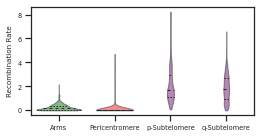

Chr domain        Arms  Pericentromere  p-Subtelomere  q-Subtelomere
n              1595.00          202.00         434.00         468.00
mean              0.23            0.09           2.06           1.87
5 percentile      0.00            0.00           0.43           0.27
50 percentile     0.14            0.01           1.69           1.78
75 percentile     0.36            0.04           2.97           2.73
95 percentile     0.71            0.21           4.28           3.74

In [27]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = '%s percentile' % n
    return percentile_

list_chromosomes = chr_sizes.Chr.to_list()


plt.figure(figsize=(4,2))
sns.set(style='ticks', font_scale=.6)
sns.despine(offset=10, trim=True);

sns.despine()
ax = sns.violinplot(y=Rec_rate[(Rec_rate.Smooth_Recombination_Rate>0) ]['Smooth_Recombination_Rate'],x=Rec_rate[(Rec_rate.Smooth_Recombination_Rate>0) ]['Chr domain'], cut=0, order =['Arms','Pericentromere','p-Subtelomere','q-Subtelomere'], palette=['green','red','purple','purple'], linewidth=1, edge=False, scale_hue=False, inner="quartile")
#plt.title('Recombination Rates\nper Chromosomal Domains')
for violin, alpha in zip(ax.collections[::], [.5,.5,.5,.5,.5]):
    violin.set_alpha(alpha)
plt.ylabel('Recombination Rate')
plt.xlabel('')
out_fig_name = os.path.join(out_dir_figs,'Xtropicalis_Rec_rate_per_chr_domains.pdf')
print("Saved as", out_fig_name)
plt.savefig(out_fig_name,bbox_inches='tight', transparent=True,)
plt.show()

Rec_rate[(Rec_rate.Smooth_Recombination_Rate>=0) ].groupby('Chr domain').Smooth_Recombination_Rate.agg(['count','mean',percentile(5),percentile(50),percentile(75),percentile(95)]).round(2).T.rename(index={'count':'n'}).to_csv(os.path.join(out_dir_figs,'Panel_C_Recomb_rate_in_chromosomal_domains__Stats.csv'), sep='\t')

Rec_rate[(Rec_rate.Smooth_Recombination_Rate>=0) ].groupby('Chr domain').Smooth_Recombination_Rate.agg(['count','mean',percentile(5),percentile(50),percentile(75),percentile(95)]).round(2).T.rename(index={'count':'n'})




In [12]:
# Obtain Kolmogorov-smirnov test

for i in Rec_rate['Chr domain'].unique():
    for j in Rec_rate['Chr domain'].unique():
        if (i !=j) & (len(Rec_rate[Rec_rate['Chr domain']==i])>1)& (len(Rec_rate[Rec_rate['Chr domain']==j])>1):
            print i,j,'\t',stats.ks_2samp(Rec_rate[(Rec_rate['Chr domain']==i) & (Rec_rate.Smooth_Recombination_Rate>0)].Smooth_Recombination_Rate,Rec_rate[(Rec_rate['Chr domain']==j) &(Rec_rate.Smooth_Recombination_Rate>0)].Smooth_Recombination_Rate)[1]#.round(4)



p-Subtelomere Arms 	3.2711289143335365e-208
p-Subtelomere Pericentromere 	4.1809131927636855e-91
p-Subtelomere q-Subtelomere 	0.006445460301019382
Arms p-Subtelomere 	3.2711289143335365e-208
Arms Pericentromere 	6.997138696261106e-37
Arms q-Subtelomere 	1.0365552765821958e-171
Pericentromere p-Subtelomere 	4.1809131927636855e-91
Pericentromere Arms 	6.997138696261106e-37
Pericentromere q-Subtelomere 	5.464307017051145e-89
q-Subtelomere p-Subtelomere 	0.006445460301019382
q-Subtelomere Arms 	1.0365552765821958e-171
q-Subtelomere Pericentromere 	5.464307017051145e-89


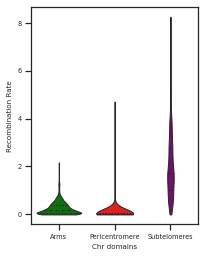

Chr domains       Arms  Pericentromere  Subtelomeres
n              1595.00          202.00        902.00
mean              0.23            0.09          1.96
5 percentile      0.00            0.00          0.32
50 percentile     0.14            0.01          1.72
75 percentile     0.36            0.04          2.77
95 percentile     0.71            0.21          4.07

In [28]:
plt.figure(figsize=(3,4))
ax = sns.violinplot(y=Rec_rate[(Rec_rate.Smooth_Recombination_Rate>0) ]['Smooth_Recombination_Rate'],x=Rec_rate[(Rec_rate.Smooth_Recombination_Rate>0) ]['Chr domains'], cut=0, order =['Arms','Pericentromere','Subtelomeres'], palette=['green','red','purple','purple'], linewidth=1, edge=False, scale_hue=False, inner="quartile")

#sns.violinplot(y=Rec_rate[(Rec_rate.Smooth_Recombination_Rate>=0) ]['Smooth_Recombination_Rate'],x=Rec_rate[(Rec_rate.Smooth_Recombination_Rate>0) ]['Chr domains'], cut=0)
plt.ylabel('Recombination Rate')
plt.show()

Rec_rate[(Rec_rate.Smooth_Recombination_Rate>=0)].groupby('Chr domains').Smooth_Recombination_Rate.agg(['count','mean',percentile(5),percentile(50),percentile(75),percentile(95)]).round(2).T.rename(index={'count':'n'})



In [30]:
for i in Rec_rate['Chr domains'].unique():
    for j in Rec_rate['Chr domains'].unique():
        if (i !=j) & (len(Rec_rate[Rec_rate['Chr domain']==i])>1)& (len(Rec_rate[Rec_rate['Chr domains']==j])>1):
            print(i,j,'\t',stats.ks_2samp(Rec_rate[(Rec_rate['Chr domain']==i ) & (Rec_rate.Smooth_Recombination_Rate>=0)].Smooth_Recombination_Rate,Rec_rate[(Rec_rate['Chr domains']==j)  & (Rec_rate.Smooth_Recombination_Rate>=0)].Smooth_Recombination_Rate)[1])  #.round(4)


Arms Subtelomeres 	 6.47e-322
Arms Pericentromere 	 1.583549116350103e-42
Pericentromere Subtelomeres 	 1.346291686595541e-168
Pericentromere Arms 	 1.583549116350103e-42
